In [4]:
import pandas as pd
import numpy as np
import pandas.util.testing as tm
import seaborn as sns
sns.set()
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import os
import datetime 
import math
import re

__IMPORT I BADANIE DANYCH__

In [65]:
df = pd.read_csv('data/AmesHousing.csv')

In [66]:
df.head(10)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
5,6,527105030,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,195500
6,7,527127150,120,RL,41.0,4920,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,213500
7,8,527145080,120,RL,43.0,5005,Pave,NaN,IR1,HLS,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,191500
8,9,527146030,120,RL,39.0,5389,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,236500
9,10,527162130,60,RL,60.0,7500,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,189000


In [67]:
df = df.set_index("Order")

In [68]:
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 85)
pd.options.display.float_format = '{:20.2f}'.format
df.head(n=5)

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,20,RL,141.00,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.00,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.00,Unf,0.00,441.00,1080.00,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.00,0.00,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.00,Fin,2.00,528.00,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
2,526350040,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,CBlock,TA,TA,No,Rec,468.00,LwQ,144.00,270.00,882.00,GasA,TA,Y,SBrkr,896,0,0,896,0.00,0.00,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.00,Unf,1.00,730.00,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
3,526351010,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.00,TA,TA,CBlock,TA,TA,No,ALQ,923.00,Unf,0.00,406.00,1329.00,GasA,TA,Y,SBrkr,1329,0,0,1329,0.00,0.00,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.00,Unf,1.00,312.00,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
4,526353030,20,RL,93.00,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.00,Gd,TA,CBlock,TA,TA,No,ALQ,1065.00,Unf,0.00,1045.00,2110.00,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.00,0.00,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.00,Fin,2.00,522.00,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
5,527105010,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,PConc,Gd,TA,No,GLQ,791.00,Unf,0.00,137.00,928.00,GasA,Gd,Y,SBrkr,928,701,0,1629,0.00,0.00,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.00,Fin,2.00,482.00,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [69]:
print("Shape of df: ", df.shape)

Shape of df:  (2930, 81)


In [70]:
ProfileReport(df, title='Opis danych', minimal=True)
#profile.to_file(output_file="raport_min.html") #możliwość wyrzucenia raportu do pliku HTML

NameError: name 'ProfileReport' is not defined

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2930 entries, 1 to 2930
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PID              2930 non-null   int64  
 1   MS SubClass      2930 non-null   int64  
 2   MS Zoning        2930 non-null   object 
 3   Lot Frontage     2440 non-null   float64
 4   Lot Area         2930 non-null   int64  
 5   Street           2930 non-null   object 
 6   Alley            198 non-null    object 
 7   Lot Shape        2930 non-null   object 
 8   Land Contour     2930 non-null   object 
 9   Utilities        2930 non-null   object 
 10  Lot Config       2930 non-null   object 
 11  Land Slope       2930 non-null   object 
 12  Neighborhood     2930 non-null   object 
 13  Condition 1      2930 non-null   object 
 14  Condition 2      2930 non-null   object 
 15  Bldg Type        2930 non-null   object 
 16  House Style      2930 non-null   object 
 17  Overall Qual  

In [72]:
df.describe(include=[np.number], percentiles=[.5]) \
    .transpose().drop("count", axis=1)

,mean,std,min,50%,max
PID,714464496.99,188730844.65,526301100.00,535453620.00,1007100110.00
MS SubClass,57.39,42.64,20.00,50.00,190.00
Lot Frontage,69.22,23.37,21.00,68.00,313.00
Lot Area,10147.92,7880.02,1300.00,9436.50,215245.00
Overall Qual,6.09,1.41,1.00,6.00,10.00
Overall Cond,5.56,1.11,1.00,5.00,9.00
Year Built,1971.36,30.25,1872.00,1973.00,2010.00
Year Remod/Add,1984.27,20.86,1950.00,1993.00,2010.00
Mas Vnr Area,101.90,179.11,0.00,0.00,1600.00
BsmtFin SF 1,442.63,455.59,0.00,370.00,5644.00


In [73]:
f = open("data_description.txt", "r")
print(f.read())

FileNotFoundError: [Errno 2] No such file or directory: 'data_description.txt'

In [74]:
obj = list(df.loc[:,df.dtypes == 'object'].columns.values)
obj

['MS Zoning',
 'Street',
 'Alley',
 'Lot Shape',
 'Land Contour',
 'Utilities',
 'Lot Config',
 'Land Slope',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Exter Qual',
 'Exter Cond',
 'Foundation',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Heating',
 'Heating QC',
 'Central Air',
 'Electrical',
 'Kitchen Qual',
 'Functional',
 'Fireplace Qu',
 'Garage Type',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond',
 'Paved Drive',
 'Pool QC',
 'Fence',
 'Misc Feature',
 'Sale Type',
 'Sale Condition']

In [75]:
df.describe(include=[np.object]).transpose() \
    .drop("count", axis=1)

,unique,top,freq
MS Zoning,7,RL,2273
Street,2,Pave,2918
Alley,2,Grvl,120
Lot Shape,4,Reg,1859
Land Contour,4,Lvl,2633
Utilities,3,AllPub,2927
Lot Config,5,Inside,2140
Land Slope,3,Gtl,2789
Neighborhood,28,NAmes,443
Condition 1,9,Norm,2522


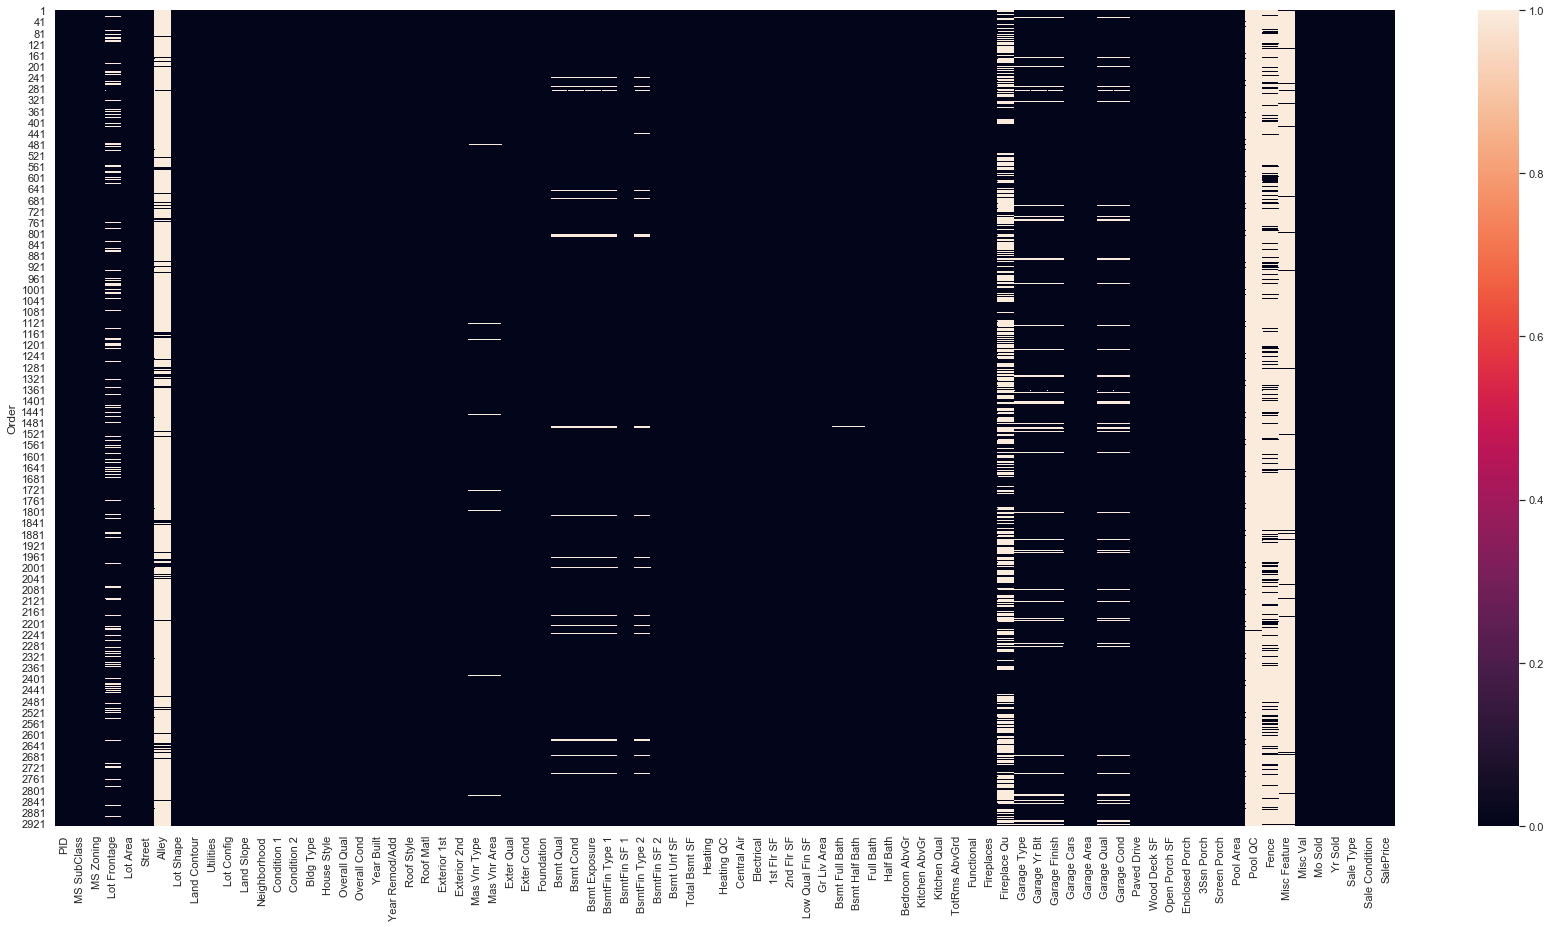

In [76]:
plt.figure(figsize=(30,15))
sns.heatmap(df.isnull())

In [77]:
df['SalePrice'].describe()

count                2930.00
mean               180796.06
std                 79886.69
min                 12789.00
25%                129500.00
50%                160000.00
75%                213500.00
max                755000.00
Name: SalePrice, dtype: float64

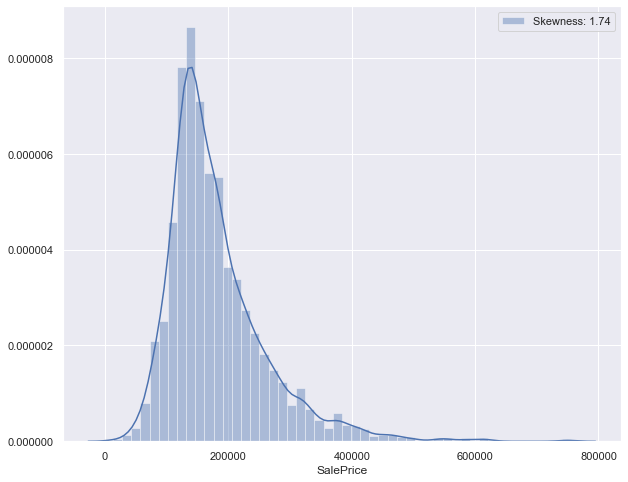

In [78]:
plt.figure(figsize=(10,8))
bar = sns.distplot(df['SalePrice'])
bar.legend(["Skewness: {:.2f}".format(df['SalePrice'].skew())]);

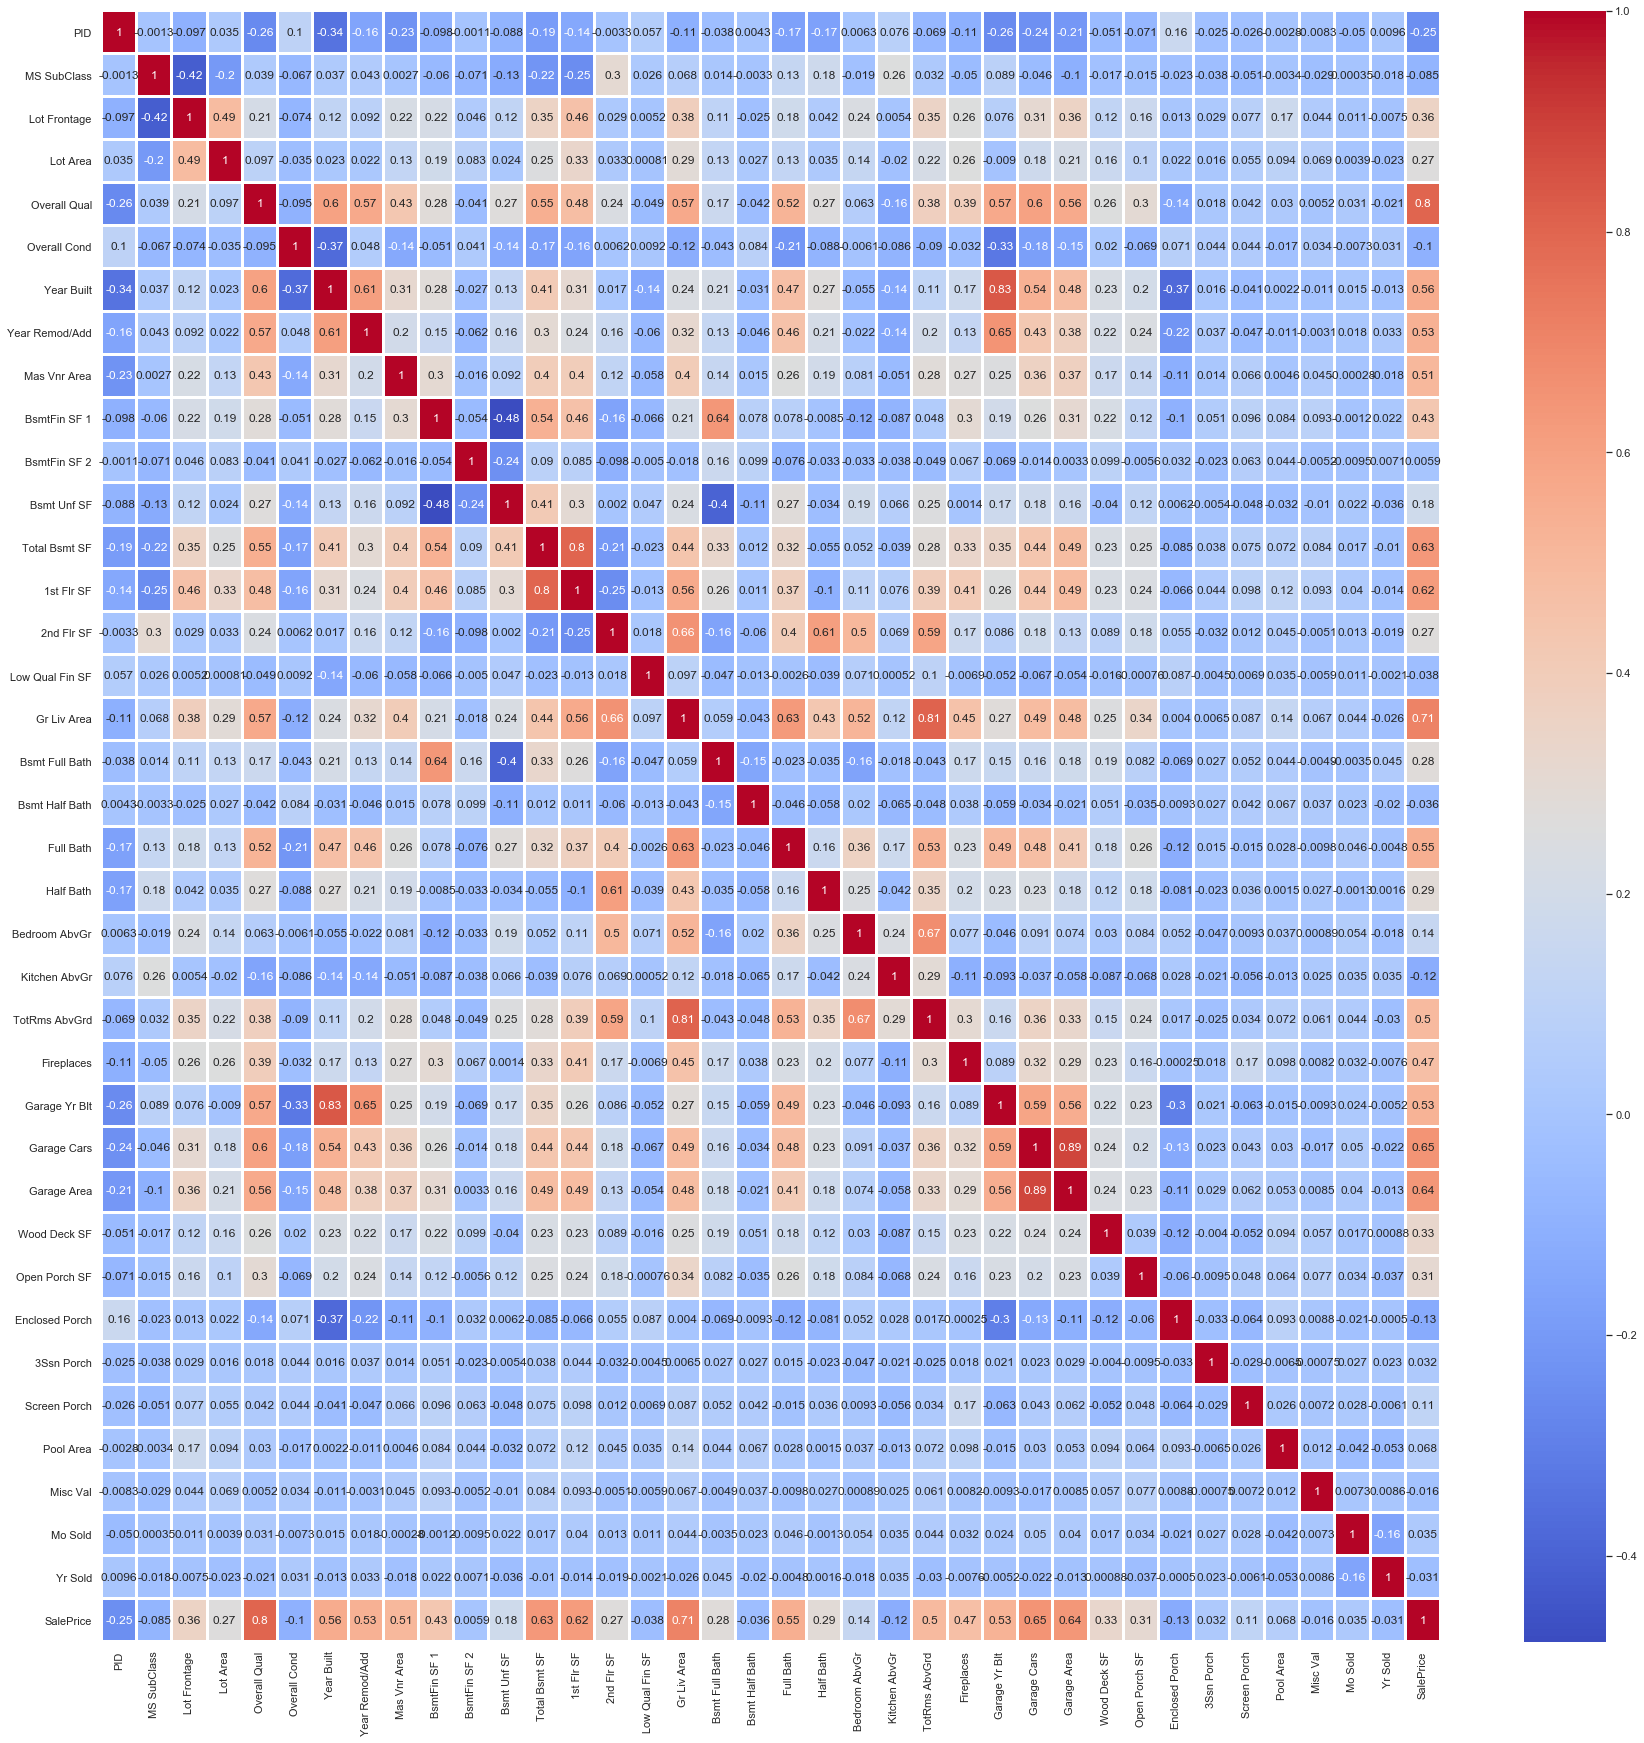

In [79]:
plt.figure(figsize=(30,30))
ax = sns.heatmap(df.corr(), cmap = "coolwarm", annot=True, linewidth=2)


In [80]:
high_corr = df.corr()
high_corr_features = high_corr.index[abs(high_corr["SalePrice"]) >= 0.5]
high_corr_features

Index(['Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'Full Bath',
       'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'SalePrice'],
      dtype='object')

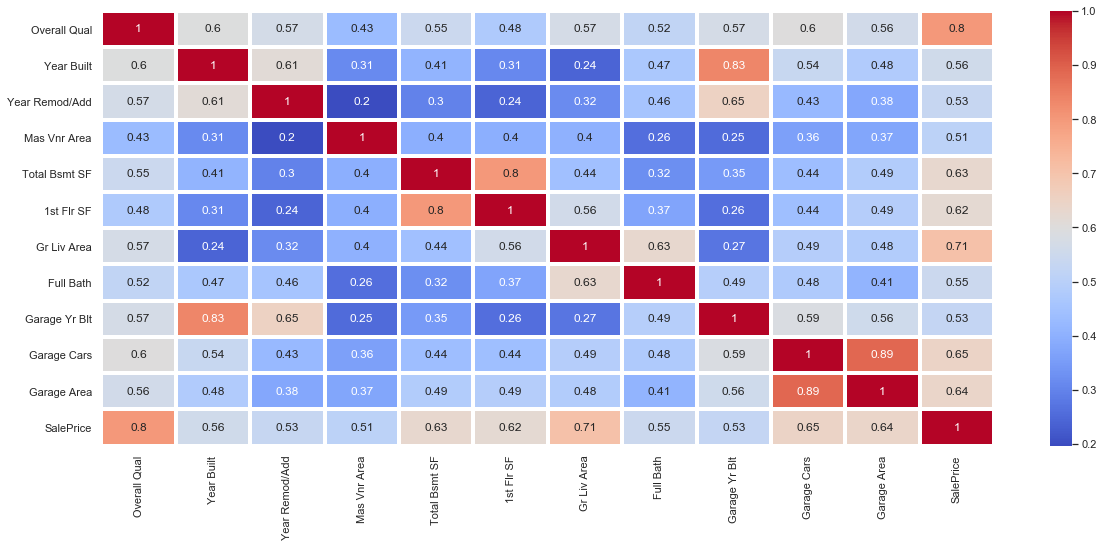

In [81]:
plt.figure(figsize=(20,8))
ax = sns.heatmap(df[high_corr_features].corr(), cmap = "coolwarm", annot=True, linewidth=3)

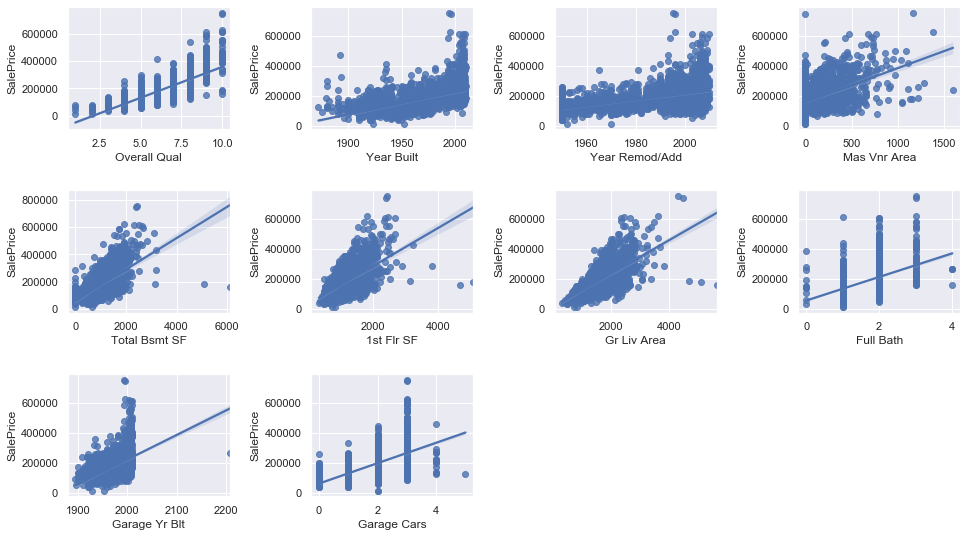

In [82]:
plt.figure(figsize=(16,9))
for i in range(len(high_corr_features)):
    if i <= 9:
        plt.subplot(3,4,i+1)
        plt.subplots_adjust(hspace = 0.5,wspace = 0.5)
        sns.regplot(data=df, x = high_corr_features[i], y = 'SalePrice')

__BRAKI W DANYCH - UZUPŁNIENIE DANYCH__

In [83]:
num_missing = df.isna().sum()
num_missing = num_missing[num_missing > 0]
percent_missing = num_missing * 100 / df.shape[0]
pd.concat([num_missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)

,Missing Values,Percentage
Pool QC,2917,99.56
Misc Feature,2824,96.38
Alley,2732,93.24
Fence,2358,80.48
Fireplace Qu,1422,48.53
Lot Frontage,490,16.72
Garage Cond,159,5.43
Garage Qual,159,5.43
Garage Finish,159,5.43
Garage Yr Blt,159,5.43


In [84]:
missing_col = df.columns[df.isnull().any()]
missing_col

Index(['Lot Frontage', 'Alley', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Electrical', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars',
       'Garage Area', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence',
       'Misc Feature'],
      dtype='object')

In [85]:
df["Pool QC"].fillna("No Pool", inplace=True)
df['Misc Feature'].fillna('No feature', inplace=True)
df['Alley'].fillna('No Alley', inplace=True)
df['Fence'].fillna('No Fence', inplace=True)
df['Fireplace Qu'].fillna('No Fireplace', inplace=True)
df['Lot Frontage'].fillna(0, inplace=True)
df['Mas Vnr Area'].fillna(0, inplace=True)
df['Mas Vnr Type'].fillna("None", inplace=True)
df['Electrical'].fillna(df['Electrical'].mode()[0], inplace=True)

In [86]:
garage_columns = [col for col in df.columns if col.startswith("Garage")]
df[df['Garage Cars'].isna()][garage_columns]

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
Order,,,,,,,
2237,Detchd,nan,NaN,nan,nan,NaN,NaN


In [87]:
df[~pd.isna(df['Garage Type']) & 
        pd.isna(df['Garage Qual'])][garage_columns]

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
Order,,,,,,,
1357,Detchd,nan,NaN,1.00,360.00,NaN,NaN
2237,Detchd,nan,NaN,nan,nan,NaN,NaN


In [88]:
df['Garage Cars'].fillna(0, inplace=True)
df['Garage Area'].fillna(0, inplace=True)

df.loc[~pd.isna(df['Garage Type']) & 
            pd.isna(df['Garage Qual']), "Garage Type"] = "No Garage"

for col in ['Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond']:
    df[col].fillna('No Garage', inplace=True)
    
df['Garage Yr Blt'].fillna(0, inplace=True)

In [89]:
bsmt_columns = [col for col in df.columns if "Bsmt" in col]
df[df['Bsmt Half Bath'].isna()][bsmt_columns]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
Order,,,,,,,,,,,
1342,NaN,NaN,NaN,NaN,nan,NaN,nan,nan,nan,nan,nan
1498,NaN,NaN,NaN,NaN,0.00,NaN,0.00,0.00,0.00,nan,nan


In [90]:
df[~pd.isna(df['Bsmt Cond']) & 
        pd.isna(df['Bsmt Exposure'])][bsmt_columns]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
Order,,,,,,,,,,,
67,Gd,TA,NaN,Unf,0.00,Unf,0.00,1595.00,1595.00,0.00,0.00
1797,Gd,TA,NaN,Unf,0.00,Unf,0.00,725.00,725.00,0.00,0.00
2780,Gd,TA,NaN,Unf,0.00,Unf,0.00,936.00,936.00,0.00,0.00


In [91]:
df[~pd.isna(df['Bsmt Cond']) & 
        pd.isna(df['BsmtFin Type 2'])][bsmt_columns]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
Order,,,,,,,,,,,
445,Gd,TA,No,GLQ,1124.00,NaN,479.00,1603.00,3206.00,1.00,0.00


In [92]:
for col in ["Bsmt Half Bath", "Bsmt Full Bath", "Total Bsmt SF", 
            "Bsmt Unf SF", "BsmtFin SF 2", "BsmtFin SF 1"]:
    df[col].fillna(0, inplace=True)

df.loc[~pd.isna(df['Bsmt Cond']) & 
            pd.isna(df['Bsmt Exposure']), "Bsmt Exposure"] = "No"
df.loc[~pd.isna(df['Bsmt Cond']) & 
            pd.isna(df['BsmtFin Type 2']), "BsmtFin Type 2"] = "Unf"

for col in ["Bsmt Exposure", "BsmtFin Type 2", 
            "BsmtFin Type 1", "Bsmt Qual", "Bsmt Cond"]:
    df[col].fillna("No Basement", inplace=True)

In [93]:
df.drop(['PID'], axis=1, inplace=True)

In [94]:
df['Total Flors'] = df['Total Flors']

KeyError: 'Total Flors'

In [95]:
df.isna().values.sum()

0

__Zamiana zmiennych kategorczynych__

In [96]:
mp = {'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0}
df['Exter Qual'] = df['Exter Qual'].map(mp)
df['Exter Cond'] = df['Exter Cond'].map(mp)
df['Heating QC'] = df['Heating QC'].map(mp)
df['Kitchen Qual'] = df['Kitchen Qual'].map(mp)

mp = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'No Basement':0}
df['Bsmt Qual'] = df['Bsmt Qual'].map(mp)
df['Bsmt Cond'] = df['Bsmt Cond'].map(mp)
df['Bsmt Exposure'] = df['Bsmt Exposure'].map(
    {'Gd':4,'Av':3,'Mn':2,'No':1,'No Basement':0})

mp = {'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'No Basement':0}
df['BsmtFin Type 1'] = df['BsmtFin Type 1'].map(mp)
df['BsmtFin Type 2'] = df['BsmtFin Type 2'].map(mp)

df['Central Air'] = df['Central Air'].map({'Y':1,'N':0})
df['Functional'] = df['Functional'].map(
    {'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,
     'Maj2':2,'Sev':1,'Sal':0})
df['Fireplace Qu'] = df['Fireplace Qu'].map(
    {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'No Fireplace':0})
df['Garage Finish'] = df['Garage Finish'].map(
    {'Fin':3,'RFn':2,'Unf':1,'No Garage':0})
df['Garage Qual'] = df['Garage Qual'].map(
    {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'No Garage':0})
df['Garage Cond'] = df['Garage Cond'].map(
    {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'No Garage':0})
df['Pool QC'] = df['Pool QC'].map(
    {'Ex':4,'Gd':3,'TA':2,'Fa':1,'No Pool':0})
df['Land Slope'] = df['Land Slope'].map(
    {'Sev': 2, 'Mod': 1, 'Gtl': 0})
df['Fence'] = df['Fence'].map(
    {'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1,'No Fence':0})

In [97]:
df = pd.get_dummies(df)

__standaryzacja danych__

In [98]:
scaler = StandardScaler()
df.loc[:, df.columns != 'SalePrice'] = scaler.fit_transform(
    df.loc[:, df.columns != 'SalePrice'])

__Podział na x i y i zbiory treningowy i testowy__

In [99]:
y = df['SalePrice']
X = df.drop(['SalePrice'], axis=1)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=3)

## Zapisywanie wyników

In [101]:
time_string = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

In [102]:
def check_dir(name, path):
    try:
        os.mkdir("{0}/{1}".format(path,name))
    except:
        print('dir exists')

In [119]:
def cv_df(grid):
    cv = grid.n_splits_
    results = grid.cv_results_
    #### ------ nazwy parametrow
    names = list(results['params'][0].keys())
    ###----- dataframe z zestawem parametrów
    param_dict = {}
    for n in names:
        par_list = [ results['params'][i][n] for i in range(len(results['params'])) ]
        param_dict[n] = par_list
    param_pd = pd.DataFrame(param_dict)
        
    ##------ dodawanie wyników z każdego folda do wynikowego DF
    results_pd= pd.DataFrame()
    for i in range(cv):
        tmp = param_pd.copy()
        tmp['score'] = results['split{0}_test_score'.format(i)]
        results_pd = results_pd.append(tmp)
        
    time_string = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    exp = "[^(]*"
    
    name = (re.search(exp, str(grid.estimator))).group()
    
    results_pd.to_csv(f'results//{name}_{time_string}.csv')
    return results_pd

# Linear Regression

In [114]:
from sklearn.linear_model import LinearRegression

In [120]:
params = {
    "n_jobs" : [1,3,5,10,15,20,30,40,50,60]
}

regression = LinearRegression()

grid = GridSearchCV(regression, params, cv=5)
grid.fit(X_train, y_train)
cv_df(grid)








,n_jobs,score
0,1,-2765112137827198619877376.00
1,3,-2765112137827198619877376.00
2,5,-2765112137827198619877376.00
3,10,-2765112137827198619877376.00
4,15,-2765112137827198619877376.00
5,20,-2765112137827198619877376.00
6,30,-2765112137827198619877376.00
7,40,-2765112137827198619877376.00
8,50,-2765112137827198619877376.00
9,60,-2765112137827198619877376.00


## RandomForestRegressor

In [133]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [134]:
params = {
     #"min_samples_split": range(2, 21, 2),
      "min_samples_leaf": [25],
      "n_estimators": [50,90, 125],
      "max_depth": [4,7,10,13,15,20],
      "criterion": ['mse']
 }

forest = RandomForestRegressor()
grid= GridSearchCV(forest, params, cv=5)
grid.fit(X_train, y_train)
cv_df(grid)
# print(grid.best_params_)
# print(grid.score(X_test, y_test))

,criterion,max_depth,min_samples_leaf,n_estimators,score
0,mse,4,25,50,0.79
1,mse,4,25,90,0.80
2,mse,4,25,125,0.80
3,mse,7,25,50,0.82
4,mse,7,25,90,0.82
...,...,...,...,...,...
13,mse,15,25,90,0.84
14,mse,15,25,125,0.84
15,mse,20,25,50,0.84
16,mse,20,25,90,0.83


## SVR


In [135]:
from sklearn.svm import SVR

In [136]:
linear = SVR(kernel = 'linear')

c = [0.01, 0.1, 1, 10] 

params = {"gamma" : ["scale","auto"],
          "C" : c,
         }

grid = GridSearchCV(linear, params, cv = 5)
grid.fit(X_train, y_train)
cv_df(grid)

,C,gamma,score
0,0.01,scale,-0.06
1,0.01,auto,-0.06
2,0.10,scale,-0.02
3,0.10,auto,-0.02
4,1.00,scale,0.29
5,1.00,auto,0.29
6,10.00,scale,0.77
7,10.00,auto,0.77
0,0.01,scale,-0.09
1,0.01,auto,-0.09


In [137]:
poly = SVR(kernel = 'poly')

c = [0.01, 0.1, 1, 10]
degree = [x for x in range(2,10)]

params = {"gamma" : ["scale","auto"],
          "C" : c,
          "degree" : degree
         }

grid = GridSearchCV(poly, params, cv = 5)
grid.fit(X_train, y_train)
cv_df(grid)

,C,degree,gamma,score
0,0.01,2,scale,-0.07
1,0.01,2,auto,-0.07
2,0.01,3,scale,-0.07
3,0.01,3,auto,-0.07
4,0.01,4,scale,-0.07
...,...,...,...,...
59,10.00,7,auto,-0.06
60,10.00,8,scale,-0.06
61,10.00,8,auto,-0.06
62,10.00,9,scale,-0.06


In [60]:
grid.best_estimator_

{'C': 100, 'degree': 9, 'gamma': 'auto'}

In [62]:
grid.score(X_test, y_test)

Support Vector Regression MAE = 50420.199066191264


In [164]:
rbf = SVR(kernel = 'rbf', )

c = [0.01, 0.1, 1, 10]
degree = [x for x in range(2,10)]

params = {"gamma" : ["scale","auto"],
          "C" : c}

grid = GridSearchCV(rbf, params, cv = 5)
grid.fit(X_train, y_train)
cv_df(grid)

,C,gamma,score
0,0.01,scale,-0.07
1,0.01,auto,-0.07
2,0.10,scale,-0.07
3,0.10,auto,-0.07
4,1.00,scale,-0.07
5,1.00,auto,-0.07
6,10.00,scale,-0.06
7,10.00,auto,-0.06
0,0.01,scale,-0.10
1,0.01,auto,-0.10


__XGBoost__

In [130]:
def XGB_score (x_train, y_train, x_test, y_test):
    max_depth = [3, 4, 5, 6, None]
    learning_rate = [0.01, 0.05, 0.01, 0.3]
    n_estimators = [10, 50, 100, 200, 500, 2500]
    best = 0
    best_model = ''
    for d in max_depth:
        for l in learning_rate:
            for n in n_estimators:
                        model = XGBRegressor(objective="reg:squarederror", 
                              seed=123, max_depth=d, learning_rate=l, n_estimators = n)
                        model.fit(x_train,y_train)
                        score = model.score(x_test,y_test)
                        if score > best:
                            best = score
                            best_model = f'score = {score} max_depth = {d} learning_rate = {l} n_estimators = {n}'
    print(best_model)
XGB_score (X_train, y_train, X_test, y_test)

KeyboardInterrupt: 

In [52]:
def XGB_rmse (x_train, y_train, x_test, y_test):    
    max_depth = [3, 4, 5, 6, None]
    learning_rate = [0.01, 0.05, 0.01, 0.3]
    n_estimators = [10, 50, 100, 200, 500]
    best = 1000000
    best_model = ''
    for d in max_depth:
        for l in learning_rate:
            for n in n_estimators:
                        model = XGBRegressor(objective="reg:squarederror", 
                              seed=123, max_depth=d, learning_rate=l, n_estimators = n)
                        model.fit(X_train,y_train)
                        y_pred = model.predict(X_test)
                        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
                        if rmse < best:
                            best = rmse
                            best_model = f'rmse = {rmse} max_depth = {d} learning_rate = {l} n_estimators = {n}'
    print(best_model)
XGB_rmse (X_train, y_train, X_test, y_test)

rmse = 19156.757268922785 max_depth = 4 learning_rate = 0.05 n_estimators = 500


__XGBoost with RandomizedSearchCV__

In [ ]:
parameter_space = \
    {
        "max_depth": [4, 5, 6],
        "learning_rate": [0.005, 0.009, 0.01],
        "n_estimators": [700, 1000, 2500],
        "booster": ["gbtree",],
        "gamma": [7, 25, 100],
        "subsample": [0.3, 0.6],
        "colsample_bytree": [0.5, 0.7],
        "colsample_bylevel": [0.5, 0.7,],
        "reg_alpha": [1, 10, 33],
        "reg_lambda": [1, 3, 10],
    }

clf = RandomizedSearchCV(XGBRegressor(random_state=3), 
                         parameter_space, cv=3, n_jobs=4,
                         scoring="neg_mean_absolute_error", 
                         random_state=3, n_iter=10)

clf.fit(X_train, y_train)
print("Best parameters:")
print(clf.best_params_)

In [39]:
xgb_model = XGBRegressor(**clf.best_params_)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, y_pred)
print("XGBoost MAE =", xgb_mae)

XGBoost MAE = 12111.19181659277


__XGBoost waga featurów__

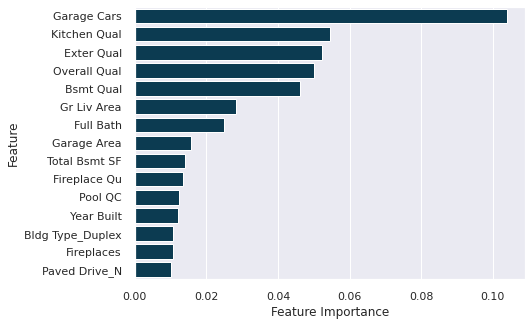

In [63]:
xgb_feature_importances = xgb_model.feature_importances_
xgb_feature_importances = pd.Series(
    xgb_feature_importances, index=X_train.columns.values
    ).sort_values(ascending=False).head(15)

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x=xgb_feature_importances, 
            y=xgb_feature_importances.index, 
            color="#003f5c");
plt.xlabel('Feature Importance');
plt.ylabel('Feature');

__SVR with gridsearch__

In [131]:
parameter_space = \
    {
        "kernel": ["poly", "linear", "rbf", "sigmoid"],
        "degree": [3, 5],
        "coef0": [0, 3, 7],
        "gamma":[.001, 0.01, 1/X_train.shape[1]],
        "C": [1, 10, 100],
    }

clf = GridSearchCV(SVR(), parameter_space, cv=3, n_jobs=4,
                   scoring="neg_mean_absolute_error")

clf.fit(X_train, y_train)
cv_df(clf)
print("Best parameters:")
print(clf.best_params_)

NameError: name 'SVR' is not defined

In [59]:
svr_model = SVR(**clf.best_params_)
svr_model.fit(X_train, y_train)
y_pred = svr_model.predict(X_test)
svr_mae = mean_absolute_error(y_test, y_pred)
print("Support Vector Regression MAE =", svr_mae)

Support Vector Regression MAE = 12675.935524811264


__plotowanie wyników, na razie bez DataFrame'a
wyniki przykładowe__

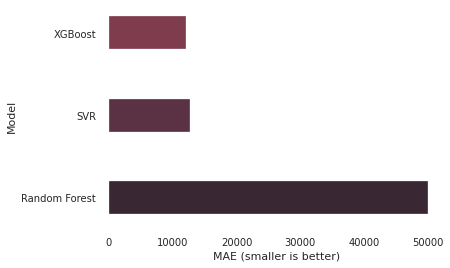

In [12]:
x = ['Random Forest', 'SVR', 'XGBoost']
y = [50000.00, 12675.93, 12111.19]
colors = ["#392834", "#5a3244", "#7e3c4d"]
fig, ax = plt.subplots()
plt.barh(y=range(len(x)), tick_label=x, width=y, height=0.4, color=colors);
ax.set(xlabel="MAE (smaller is better)", ylabel="Model");

__KNeighborsRegressor__

In [5]:
def KNN_score (X_train, y_train, X_test, y_test):
    n_neighbors = [3, 4, 5, 6]
    weights = ['uniform','distance']
    algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
    leaf_size = [10, 30, 30, 50, 50]
    best = 0
    best_model = ''
    for w in weights:
        for l in leaf_size:
            for n in n_neighbors:
                for a in algorithm:
                        model = KNeighborsRegressor(algorithm = a, 
                                weights = w, leaf_size = l, n_neighbors = n)
                        model.fit(X_train,y_train)
                        score = model.score(X_test,y_test)
                        if score > best:
                            best = score
                            best_model = f'score = {score} algorithm = {a} weights = {w} leaf_size = {l} n_neighbors = {n}'
    print(best_model)

In [44]:
def KNN_rmse (x_train, y_train, x_test, y_test): 
    n_neighbors = [3, 4, 5, 6]
    weights = ['uniform','distance']
    algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
    leaf_size = [10, 30, 30, 50, 50]
    best = 100000
    best_model = ''
    for w in weights:
        for l in leaf_size:
            for n in n_neighbors:
                for a in algorithm:
                        model = KNeighborsRegressor(algorithm = a, 
                                weights = w, leaf_size = l, n_neighbors = n)
                        model.fit(X_train,y_train)
                        y_pred = model.predict(X_test)
                        mse = mean_squared_error(y_test, y_pred)
                        y_pred = model.predict(X_test)
                        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
                        if rmse < best:
                            best = rmse
                            best_model = f'rmse = {rmse} algorithm = {a} weights = {w} leaf_size = {l} n_neighbors = {n}'
    print(best_model)

In [51]:
KNN_score(X_train, y_train, X_test, y_test)

score = 0.7760308147468868 algorithm = auto weights = distance leaf_size = 10 n_neighbors = 6


In [47]:
KNN_rmse(X_train, y_train, X_test, y_test)

rmse = 36638.186898000924 algorithm = auto weights = distance leaf_size = 10 n_neighbors = 6


In [125]:
print(os.listdir(directory))
print(directory)

['LinearRegression_20200710_194922.csv']
./results/


In [104]:
#odczytywanie wyników

In [138]:
directory = os.curdir + "/results/"

tabela = pd.DataFrame()

for file in os.listdir(directory):
    #iteracja przez wszystkie pliki w katalogu
    
    tmp = pd.read_csv("results/" + file, index_col= False) 
    
    # usunięcie zbędnej kolumny
    tmp = tmp.drop(columns = 'Unnamed: 0', axis = 0)
   
    # zkolalizowanie najwyższego score'a
    result = tmp['score'].idxmax()
    
    # przypisanie rzędu z najwyższym wyniku do słownika 
    max_score = dict(tmp.iloc[result])
    
    # wyciągnięcie nazwy modelu z pliku
    max_score['model']  = str(file).split(' ')[0]
    
    # dodanie rekordu do tabeli
    tabela = tabela.append((max_score), ignore_index = True)
    
tabela
                           
  

        



,model,n_jobs,score,criterion,max_depth,min_samples_leaf,n_estimators,C,gamma,degree
0,LinearRegression_20200710_194922.csv,1.00,-2044357372913150066688.00,NaN,nan,nan,nan,nan,NaN,nan
1,RandomForestRegressor_20200710_195914.csv,nan,0.90,mse,13.00,25.00,125.00,nan,NaN,nan
2,SVR_20200710_200437.csv,nan,0.86,NaN,nan,nan,nan,10.00,scale,nan
3,SVR_20200710_201415.csv,nan,-0.02,NaN,nan,nan,nan,10.00,auto,9.00
